In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import seaborn as sns
from Helmholtz2D_model_tf import Sampler, Helmholtz2D
import scipy.io

D:\anaconda\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\anaconda\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\anaconda\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\anaconda\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passing (type, 1) or '1ty

In [2]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
np.random.seed(1233)
tf.set_random_seed(1233)

In [3]:
if __name__ == '__main__':
    
    a_1 = 1
    a_2 = 8
    
    def u(x, a_1, a_2):
        return np.sin(a_1 * np.pi * x[:, 0:1]) * np.sin(a_2 * np.pi * x[:, 1:2])

    def u_xx(x, a_1, a_2):
        return - (a_1 * np.pi) ** 2 * np.sin(a_1 * np.pi * x[:, 0:1]) * np.sin(a_2 * np.pi * x[:, 1:2])

    def u_yy(x, a_1, a_2):
        return - (a_2 * np.pi) ** 2 * np.sin(a_1 * np.pi * x[:, 0:1]) * np.sin(a_2 * np.pi * x[:, 1:2])

    # Forcing
    def f(x, a_1, a_2, lam):
        return u_xx(x, a_1, a_2) + u_yy(x, a_1, a_2) + lam * u(x, a_1, a_2)

    def operator(u, x1, x2, lam, sigma_x1=1.0, sigma_x2=1.0):
        u_x1 = tf.gradients(u, x1)[0] / sigma_x1
        u_x2 = tf.gradients(u, x2)[0] / sigma_x2
        u_xx1 = tf.gradients(u_x1, x1)[0] / sigma_x1
        u_xx2 = tf.gradients(u_x2, x2)[0] / sigma_x2
        residual = u_xx1 + u_xx2 + lam * u
        return residual

    # Parameter
    lam = 1.0

    # Domain boundaries
    bc1_coords = np.array([[-1.0, -1.0],
                           [1.0, -1.0]])
    bc2_coords = np.array([[1.0, -1.0],
                           [1.0, 1.0]])
    bc3_coords = np.array([[1.0, 1.0],
                           [-1.0, 1.0]])
    bc4_coords = np.array([[-1.0, 1.0],
                           [-1.0, -1.0]])

    dom_coords = np.array([[-1.0, -1.0],
                           [1.0, 1.0]])

    # Create initial conditions samplers
    ics_sampler = None

    # Create boundary conditions samplers
    bc1 = Sampler(2, bc1_coords, lambda x: u(x, a_1, a_2), name='Dirichlet BC1')
    bc2 = Sampler(2, bc2_coords, lambda x: u(x, a_1, a_2), name='Dirichlet BC2')
    bc3 = Sampler(2, bc3_coords, lambda x: u(x, a_1, a_2), name='Dirichlet BC3')
    bc4 = Sampler(2, bc4_coords, lambda x: u(x, a_1, a_2), name='Dirichlet BC4')
    bcs_sampler = [bc1, bc2, bc3, bc4]

    # Create residual sampler
    res_sampler = Sampler(2, dom_coords, lambda x: f(x, a_1, a_2, lam), name='Forcing')

    # Define model
    mode = 'M4'            # Method: 'M1', 'M2', 'M3', 'M4'
    stiff_ratio = False    # Log the eigenvalues of Hessian of losses

    layers = [2, 50, 50, 50,50, 1]
    model = Helmholtz2D(layers, operator, ics_sampler, bcs_sampler, res_sampler, lam, mode, stiff_ratio)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [4]:
    # Train model
    model.train(nIter=40001, batch_size=128)

It: 0, Loss: 1.213e+05, Loss_bcs: 7.083e-01, Loss_res: 1.213e+05, Adaptive_Constant: 89.24 ,Time: 12.67
Gradients information stored ...
It: 1000, Loss: 4.197e+04, Loss_bcs: 1.500e+02, Loss_res: 4.182e+04, Adaptive_Constant: 91.90 ,Time: 48.20
It: 2000, Loss: 5.591e+03, Loss_bcs: 1.791e+02, Loss_res: 5.412e+03, Adaptive_Constant: 130.95 ,Time: 10.64
It: 3000, Loss: 4.255e+03, Loss_bcs: 3.820e+01, Loss_res: 4.217e+03, Adaptive_Constant: 140.28 ,Time: 10.62
It: 4000, Loss: 1.201e+03, Loss_bcs: 2.011e+01, Loss_res: 1.181e+03, Adaptive_Constant: 165.29 ,Time: 10.52
It: 5000, Loss: 3.250e+02, Loss_bcs: 1.116e+01, Loss_res: 3.138e+02, Adaptive_Constant: 162.61 ,Time: 12.88
It: 6000, Loss: 2.270e+02, Loss_bcs: 1.018e+01, Loss_res: 2.168e+02, Adaptive_Constant: 163.58 ,Time: 14.51
It: 7000, Loss: 1.803e+02, Loss_bcs: 5.885e+00, Loss_res: 1.745e+02, Adaptive_Constant: 179.22 ,Time: 14.57
It: 8000, Loss: 1.641e+02, Loss_bcs: 3.982e+00, Loss_res: 1.602e+02, Adaptive_Constant: 196.15 ,Time: 14.42


In [5]:
    # Test data
    nn = 100
    x1 = np.linspace(dom_coords[0, 0], dom_coords[1, 0], nn)[:, None]
    x2 = np.linspace(dom_coords[0, 1], dom_coords[1, 1], nn)[:, None]
    x1, x2 = np.meshgrid(x1, x2)
    X_star = np.hstack((x1.flatten()[:, None], x2.flatten()[:, None]))

    # Exact solution
    u_star = u(X_star, a_1, a_2)
    f_star = f(X_star, a_1, a_2, lam)

    # Predictions
    u_pred = model.predict_u(X_star)
    f_pred = model.predict_r(X_star)

    # Relative error
    error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
    error_f = np.linalg.norm(f_star - f_pred, 2) / np.linalg.norm(f_star, 2)

    print('Relative L2 error_u: {:.2e}'.format(error_u))
    print('Relative L2 error_u: {:.2e}'.format(error_f))

Relative L2 error_u: 3.42e-02
Relative L2 error_u: 1.09e-02


D:\anaconda\envs\tf\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if sys.path[0] == '':
D:\anaconda\envs\tf\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
D:\anaconda\envs\tf\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilate

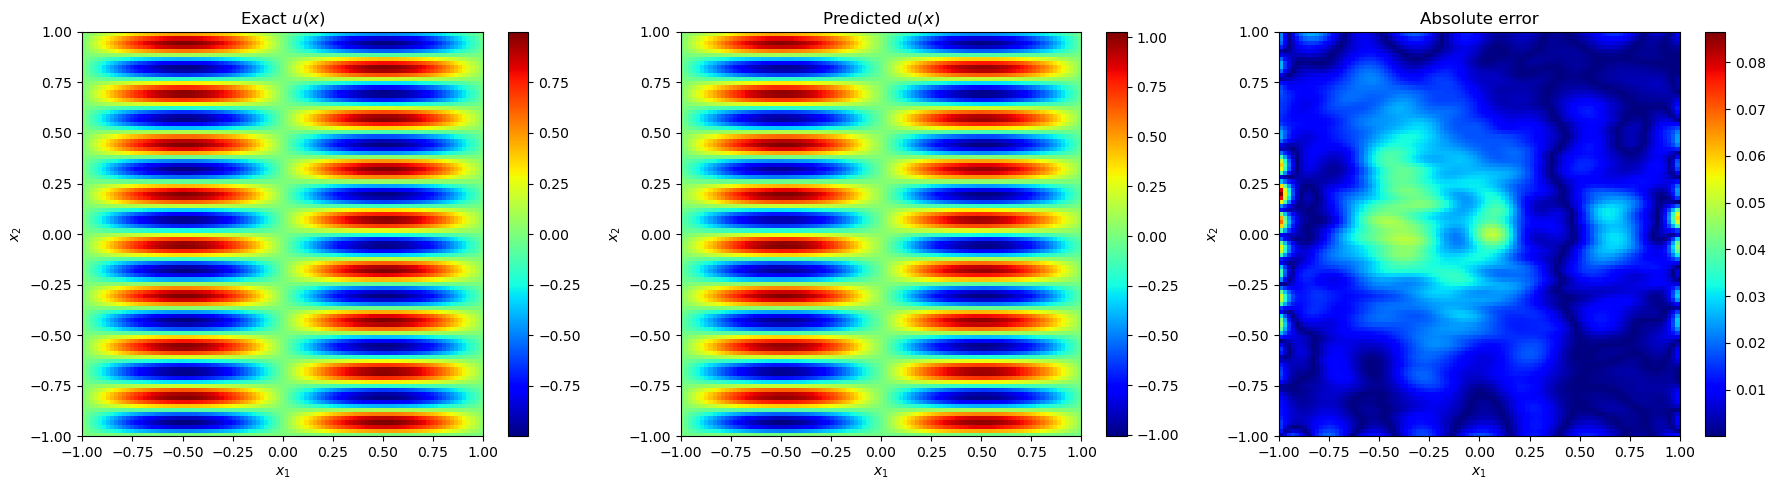

In [6]:
    # Exact solution & Predicted solution
    # Exact soluton
    U_star = griddata(X_star, u_star.flatten(), (x1, x2), method='cubic')
    F_star = griddata(X_star, f_star.flatten(), (x1, x2), method='cubic')

    # Predicted solution
    U_pred = griddata(X_star, u_pred.flatten(), (x1, x2), method='cubic')
    F_pred = griddata(X_star, f_pred.flatten(), (x1, x2), method='cubic')

    fig_1 = plt.figure(1, figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.pcolor(x1, x2, U_star, cmap='jet')
    plt.colorbar()
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.title('Exact $u(x)$')

    plt.subplot(1, 3, 2)
    plt.pcolor(x1, x2, U_pred, cmap='jet')
    plt.colorbar()
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.title('Predicted $u(x)$')

    plt.subplot(1, 3, 3)
    plt.pcolor(x1, x2, np.abs(U_star - U_pred), cmap='jet')
    plt.colorbar()
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.title('Absolute error')
    plt.tight_layout()
    plt.show()